In [1]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 22.1 MB/s eta 0:00:0000:01


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/blood-cells")

print("Path to dataset files:", path)

Mounting files to /kaggle/input/datasets/paultimothymooney/blood-cells...
Path to dataset files: /kaggle/input/datasets/paultimothymooney/blood-cells


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz



image_folder = "/kaggle/input/datasets/paultimothymooney/blood-cells/dataset-master/dataset-master/JPEGImages"

image_files = sorted(os.listdir(image_folder))[:30]   # Only first 30 images
print("Using images:", len(image_files))

Using images: 30


In [4]:
def preprocess(img):
    img = cv2.resize(img, (256, 256))
    img = cv2.GaussianBlur(img, (5,5), 0)
    return img

In [5]:
def kmeans_segmentation(image, k=3):
    pixels = image.reshape((-1, 3))
    pixels = np.float32(pixels)

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pixels)

    segmented = labels.reshape(image.shape[:2])
    return segmented

In [6]:
def fcm_segmentation(image, c=3):
    pixels = image.reshape((-1, 3)).T
    pixels = np.float64(pixels)

    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels, c=c, m=2, error=0.005, maxiter=1000
    )

    cluster_membership = np.argmax(u, axis=0)
    segmented = cluster_membership.reshape(image.shape[:2])
    return segmented

In [7]:
def extract_nucleus(segmented, image):
    cluster_means = []
    
    for i in range(3):
        mask = (segmented == i)
        mean_intensity = np.mean(image[mask])
        cluster_means.append(mean_intensity)
    
    nucleus_cluster = np.argmin(cluster_means)
    nucleus_mask = (segmented == nucleus_cluster).astype(np.uint8)
    
    return nucleus_mask

In [8]:
kmeans_results = []
fcm_results = []

for file in image_files:
    
    img = cv2.imread(os.path.join(image_folder, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess(img)
    
    # KMeans
    k_seg = kmeans_segmentation(img)
    k_nucleus = extract_nucleus(k_seg, img)
    
    # FCM
    f_seg = fcm_segmentation(img)
    f_nucleus = extract_nucleus(f_seg, img)
    
    kmeans_results.append(k_nucleus)
    fcm_results.append(f_nucleus)

print("Segmentation Completed for 30 images.")

Segmentation Completed for 30 images.


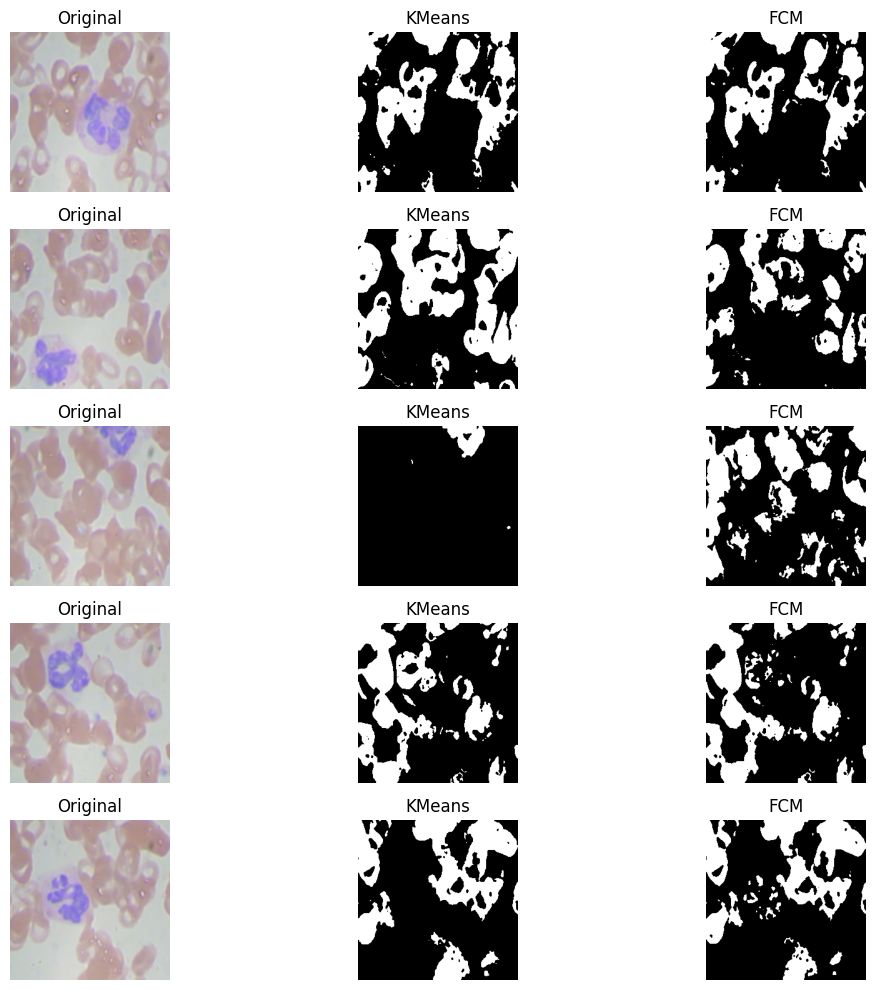

In [9]:
plt.figure(figsize=(12,10))

for i in range(5):
    
    img = cv2.imread(os.path.join(image_folder, image_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess(img)
    
    plt.subplot(5,3,i*3+1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(5,3,i*3+2)
    plt.imshow(kmeans_results[i], cmap='gray')
    plt.title("KMeans")
    plt.axis("off")
    
    plt.subplot(5,3,i*3+3)
    plt.imshow(fcm_results[i], cmap='gray')
    plt.title("FCM")
    plt.axis("off")

plt.tight_layout()
plt.show()